##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [158]:
orig_df = pd.read_csv('/content/drive/MyDrive/PR/Dataset/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [159]:
df = pd.read_csv('/content/drive/MyDrive/PR/Dataset/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [160]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [161]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [162]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [163]:
df.head()


,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [164]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


Input variable = X,Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time

Target variables = VictimCount

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [165]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Create a MinMaxScaler instance and apply it to input features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['VictimCount'], test_size=0.2, random_state=42)

# Convert to PyTorch tensors and create DataLoader objects
batch_size = 50
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)),
                         batch_size=batch_size, shuffle=False)

# Verify the shape of the data by iterating over one dataset
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break


Input shape: torch.Size([50, 6])
Target shape: torch.Size([50])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
    --->MSELoss
* what should the size of the predicted output be?
    --->The size of the predicted output should be 1,
* explain your choice of architecture, including how many layers you will be using
    --->Feedforward neural network with several fully connected layers.Number of layer = 6
        
* define an optimizer for training this model, choose a proper learning rate
    ---> Optimizer = Adam, Learning rate = 0.0001
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [166]:
import copy
import torch.nn as nn
import torch.optim as optim

# Define a new model with modified variable names
my_model = nn.Sequential(
    nn.Linear(6, 224),  # Input layer with 6 input features and 256 hidden units
    nn.ReLU(),
    nn.Linear(224, 124),  # Hidden layer with 128 units
    nn.Tanh(),
    nn.Linear(124, 16),  # Another hidden layer with 64 units
    nn.ReLU(),
    nn.Linear(16, 8),  # Output layer with a single unit (for regression)
    nn.Tanh(),
    nn.Linear(8, 1)
)

# Loss function and optimizer
my_loss_function = nn.MSELoss()  # Mean square error
my_optimizer = optim.Adam(my_model.parameters(), lr=0.0001)

number_of_epochs = 100  # Number of epochs to run
training_history = []

best_mean_squared_error = float('inf')  # Initialize to positive infinity
best_weights_copy = None

for current_epoch in range(number_of_epochs):
    my_model.train()  # Set the model in training mode
    current_running_loss = 0.0
    current_running_mse = 0.0

    for current_inputs, current_targets in train_loader:
        my_optimizer.zero_grad()
        current_outputs = my_model(current_inputs)
        current_loss = my_loss_function(current_outputs, current_targets)
        current_loss.backward()
        my_optimizer.step()
        current_running_loss += current_loss.item()
        current_running_mse += ((current_outputs - current_targets) ** 2).mean().item()

    current_average_loss = current_running_loss / len(train_loader)
    current_average_mse = current_running_mse / len(train_loader)
    training_history.append(current_average_loss)

    print(f'Epoch [{current_epoch + 1}/{number_of_epochs}] - Loss: {current_average_loss:.4f} - MSE: {current_average_mse:.4f}')

    if current_average_mse < best_mean_squared_error:
        best_mean_squared_error = current_average_mse
        best_weights_copy = copy.deepcopy(my_model.state_dict())


Epoch [1/100] - Loss: 1.4421 - MSE: 1.4421
Epoch [2/100] - Loss: 1.7670 - MSE: 1.7670
Epoch [3/100] - Loss: 1.4269 - MSE: 1.4269
Epoch [4/100] - Loss: 1.4502 - MSE: 1.4502
Epoch [5/100] - Loss: 1.6247 - MSE: 1.6247
Epoch [6/100] - Loss: 1.3800 - MSE: 1.3800
Epoch [7/100] - Loss: 1.3323 - MSE: 1.3323
Epoch [8/100] - Loss: 1.3318 - MSE: 1.3318
Epoch [9/100] - Loss: 1.4455 - MSE: 1.4455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [10/100] - Loss: 1.5701 - MSE: 1.5701
Epoch [11/100] - Loss: 1.3475 - MSE: 1.3475
Epoch [12/100] - Loss: 1.2827 - MSE: 1.2827
Epoch [13/100] - Loss: 1.3092 - MSE: 1.3092
Epoch [14/100] - Loss: 1.2586 - MSE: 1.2586
Epoch [15/100] - Loss: 1.2584 - MSE: 1.2584
Epoch [16/100] - Loss: 1.1473 - MSE: 1.1473
Epoch [17/100] - Loss: 1.1441 - MSE: 1.1441
Epoch [18/100] - Loss: 1.2278 - MSE: 1.2278
Epoch [19/100] - Loss: 1.1412 - MSE: 1.1412
Epoch [20/100] - Loss: 1.0969 - MSE: 1.0969
Epoch [21/100] - Loss: 1.1424 - MSE: 1.1424
Epoch [22/100] - Loss: 1.2033 - MSE: 1.2033
Epoch [23/100] - Loss: 1.0368 - MSE: 1.0368
Epoch [24/100] - Loss: 1.0130 - MSE: 1.0130
Epoch [25/100] - Loss: 0.9917 - MSE: 0.9917
Epoch [26/100] - Loss: 1.0585 - MSE: 1.0585
Epoch [27/100] - Loss: 0.9813 - MSE: 0.9813
Epoch [28/100] - Loss: 0.9935 - MSE: 0.9935
Epoch [29/100] - Loss: 0.9508 - MSE: 0.9508
Epoch [30/100] - Loss: 0.9303 - MSE: 0.9303
Epoch [31/100] - Loss: 1.2711 - MSE: 1.2711
Epoch [32/100] - Loss: 0.9892 - 

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
    ---> Here I use n_classes variable by counting the unique values in the 'VictimCount' column from your dataset.
* How is the architecture different?
    ---> The neural network model consists of an input layer with 6 input features, followed by two hidden layers with 64 and 32 units, respectively, and an output layer with 'n_classes' units. This architecture is a feedforward neural network. The use of ReLU activation functions in the hidden layers and Cross-Entropy loss is typical for classification tasks.
* How is the loss function different?
    ---> Here I use Cross-Entropy Loss Which is the appropriate loss function for multi-class classification tasks
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?
    ---> I tried many networks with different hyperparameters such as learning rate, hidden layer dimensions, and the number of layers and I found best in this.

In [167]:
import torch.nn as nn

class ClassificationModel(nn.Module):
    def __init__(self, input_size, n_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        #return x
        pred_output =  self.softmax(x)
        return pred_output

# Loss function and optimizer
import torch.optim as optim
n_classes = len(df['VictimCount'].unique())
# Assuming n_classes is defined correctly
model = ClassificationModel(input_size=6, n_classes=n_classes)

my_loss_function = nn.CrossEntropyLoss()  # Cross-Entropy Loss
my_optimizer = optim.Adam(model.parameters(), lr=0.001)

number_of_epochs = 300  # Number of epochs to run
training_history = []

best_accuracy = 0.0  # Initialize to 0
best_weights_copy = None

for current_epoch in range(number_of_epochs):
    model.train()  # Set the model in training mode
    current_running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for current_inputs, current_targets in train_loader:
        current_targets = current_targets.long()
        my_optimizer.zero_grad()
        current_outputs = model(current_inputs)
        current_outputs = current_outputs.float()
        current_loss = my_loss_function(current_outputs, current_targets)
        current_loss.backward()
        my_optimizer.step()
        current_running_loss += current_loss.item()

        _, predicted_labels = torch.max(current_outputs, 1)
        correct_predictions += (predicted_labels == current_targets).sum().item()
        total_samples += current_targets.size(0)

    current_average_loss = current_running_loss / len(train_loader)
    current_accuracy = correct_predictions / total_samples
    training_history.append(current_average_loss)

    print(f'Epoch [{current_epoch + 1}/{number_of_epochs}] - Loss: {current_average_loss:.4f} - Accuracy: {current_accuracy:.4f}')

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_weights_copy = copy.deepcopy(model.state_dict())
print("Best Accuracy: {:.2f}%".format(best_accuracy * 100))

Epoch [1/300] - Loss: 1.8851 - Accuracy: 0.1591
Epoch [2/300] - Loss: 1.8077 - Accuracy: 0.5091
Epoch [3/300] - Loss: 1.7352 - Accuracy: 0.5091
Epoch [4/300] - Loss: 1.6593 - Accuracy: 0.5091
Epoch [5/300] - Loss: 1.5725 - Accuracy: 0.5091
Epoch [6/300] - Loss: 1.4837 - Accuracy: 0.5091
Epoch [7/300] - Loss: 1.3821 - Accuracy: 0.5091
Epoch [8/300] - Loss: 1.3015 - Accuracy: 0.5091
Epoch [9/300] - Loss: 1.1976 - Accuracy: 0.5091
Epoch [10/300] - Loss: 1.1458 - Accuracy: 0.5091
Epoch [11/300] - Loss: 1.1525 - Accuracy: 0.5091
Epoch [12/300] - Loss: 1.1082 - Accuracy: 0.5091
Epoch [13/300] - Loss: 1.1136 - Accuracy: 0.5091
Epoch [14/300] - Loss: 1.1162 - Accuracy: 0.5091
Epoch [15/300] - Loss: 1.1008 - Accuracy: 0.5091
Epoch [16/300] - Loss: 1.0952 - Accuracy: 0.5091
Epoch [17/300] - Loss: 1.0934 - Accuracy: 0.5091
Epoch [18/300] - Loss: 1.1083 - Accuracy: 0.5091
Epoch [19/300] - Loss: 1.0607 - Accuracy: 0.5091
Epoch [20/300] - Loss: 1.0676 - Accuracy: 0.5091
Epoch [21/300] - Loss: 1.0834

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
    ---> Here I use the Regression and Classification. But Task 4 is more straightforward with a basic feedforward architecture tailored for classification,while Task 3 is a more complex model with various hidden layers and activation functions designed for regression.
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Predicted Class  :  3
Correct Class  :  1


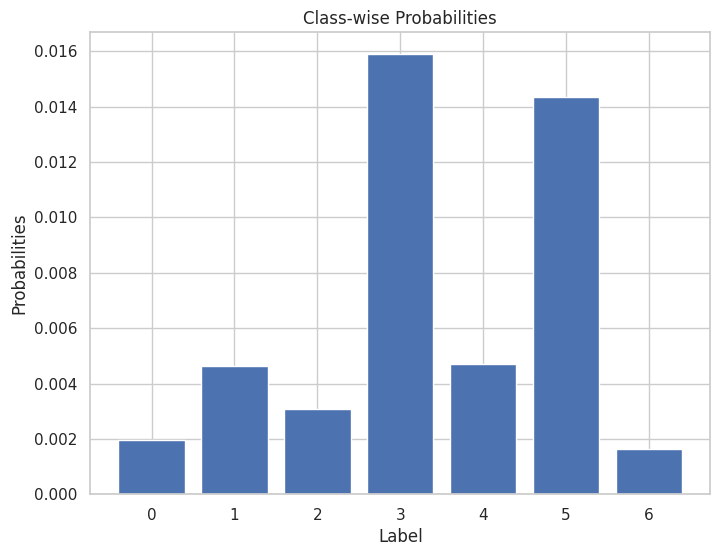

In [168]:
model.eval()
input_data = torch.tensor(X_train, dtype=torch.float).unsqueeze(0)
with torch.no_grad():
    output = model(input_data)
probabilities = torch.softmax(output, dim=1).numpy()[0]

predicted_class = np.argmax(probabilities,axis=1)

mismatch_indices = np.where(predicted_class != y_train)[0]
idx = 34
print("Predicted Class  : ",predicted_class[idx])
print("Correct Class  : ",y_train[idx])

plt.figure(figsize=(8, 6))
plt.bar(range(n_classes),probabilities[idx])
plt.xlabel('Label')
plt.ylabel('Probabilities')
plt.title('Class-wise Probabilities')
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


In [169]:
import plotly.express as px

fig = px.scatter(df, x='X', y='Y', color='VictimCount', title='Crime Incidents  - Persons Involved',
                 labels={'X': 'Latitude-X', 'Y': 'Longitude-Y', 'Victim ': 'Persons Involved'})
fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()

fig = px.scatter(df, x='X', y='Y', color='DayOfWeek', title='Crime Incidents - Day of the Week',
                 labels={'X': 'Latitude-X', 'Y': 'Longitude-Y', 'DayOfWeek': 'Day of the Week'},
                 color_continuous_scale='viridis')
fig.update_traces(marker=dict(size=8, opacity=0.7))


fig.update_layout(coloraxis_colorbar=dict(title='Day of the Week'))

fig.show()




In [170]:
import plotly.express as px

crime_by_day = df['DayOfWeek'].value_counts().sort_index()

fig = px.bar(x=crime_by_day.index, y=crime_by_day.values,
             labels={'x': 'Day of the Week', 'y': 'Number of Crimes'},
             title='Crime Frequency by Day of the Week', text=crime_by_day.values)

fig.update_traces(marker_color='skyblue')
fig.update_xaxes(categoryorder='array', categoryarray=crime_by_day.index)

fig.show()

most_f_day = crime_by_day.idxmax()
print(f"The most frequent day for crimes is: {most_f_day}")


The most frequent day for crimes is: 4
